Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

https://www.tensorflow.org/tutorials/generative/style_transfer

 Leon A. Gatys - A Neural Algorithm of Artistic Style
* https://arxiv.org/abs/1508.06576

# Settings

- Import modules

In [2]:
import tensorflow as tf

In [3]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

In [4]:
# Set plot
mpl.rcParams["figure.figsize"] = (12, 12)
mpl.rcParams["axes.grid"] = False

In [5]:
# tensor -> image

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# Load images(content image, style image)
* https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg

In [6]:
content_path = "./data/content/player.jpg"

style_path = "./data/style/athene_academy.jpg"

# Visualize Input

In [7]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [8]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

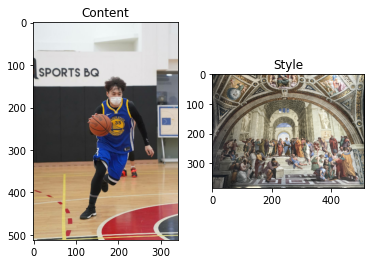

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, "Content")
plt.subplot(1, 2, 2)
imshow(style_image, "Style")

# Fast Style Transfer Using TF-HUB

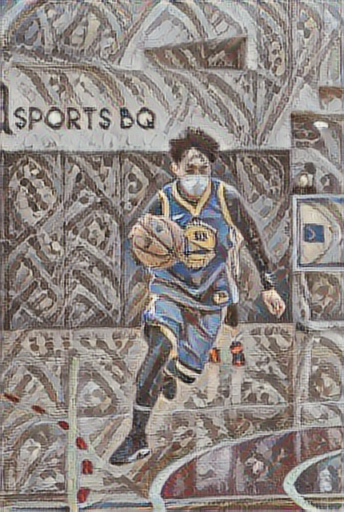

In [10]:
import tensorflow_hub as hub

hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# 콘텐츠와 스타일 표현 정의하기

Load VGG19 exception Classification layer

In [11]:
content_layers = ["block5_conv2"]

style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1",
                "block4_conv1",
                "block5_conv1",
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# 모델 만들기

In [12]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  크기: ", output.numpy().shape)
    print("  최솟값: ", output.numpy().min())
    print("  최댓값: ", output.numpy().max())
    print("  평균: ", output.numpy().mean())
    print()


block1_conv1
  크기:  (1, 384, 512, 64)
  최솟값:  0.0
  최댓값:  854.9188
  평균:  30.494698

block2_conv1
  크기:  (1, 192, 256, 128)
  최솟값:  0.0
  최댓값:  3610.4397
  평균:  190.93921

block3_conv1
  크기:  (1, 96, 128, 256)
  최솟값:  0.0
  최댓값:  11079.596
  평균:  182.44609

block4_conv1
  크기:  (1, 48, 64, 512)
  최솟값:  0.0
  최댓값:  23721.771
  평균:  704.9161

block5_conv1
  크기:  (1, 24, 32, 512)
  최솟값:  0.0
  최댓값:  3192.6711
  평균:  59.756943



# Calculate Style

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$


In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc, bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

# Extract Style and Content

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg_trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {"content":content_dict, "style":style_dict}


In [16]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.058987625
    최댓값:  46630.25
    평균:  486.21405

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  77867.27
    평균:  14612.799

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0031923854
    최댓값:  295380.16
    평균:  17606.695

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  3064626.0
    평균:  215020.48

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  112272.16
    평균:  1958.1042

콘텐츠:
   block5_conv2
    크기:  (1, 32, 21, 512)
    최솟값:  0.0
    최댓값:  2672.6396
    평균:  16.84313


# 경사하강법 실행

In [17]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [18]:
image = tf.Variable(content_image)

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [21]:
style_weight = 1e-2
content_weight = 1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_style_layers
    loss = style_loss + content_loss
    return loss


In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

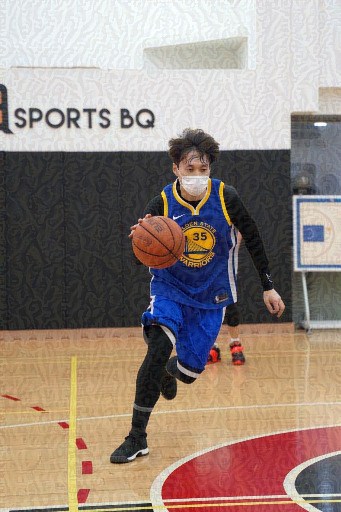

In [24]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

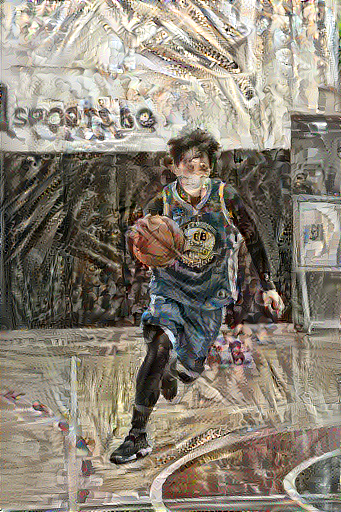

Train Step : 2048
Total Train TIme : 81.2


In [25]:
import time
start = time.time()

epochs = 16
step_per_epoch = 128

step = 0
for n in range(epochs):
    for m in range(step_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train Step : {step}")
end = time.time()
print(f"Total Train TIme : {end-start:.1f}")

# 총 변위 손실

In [26]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

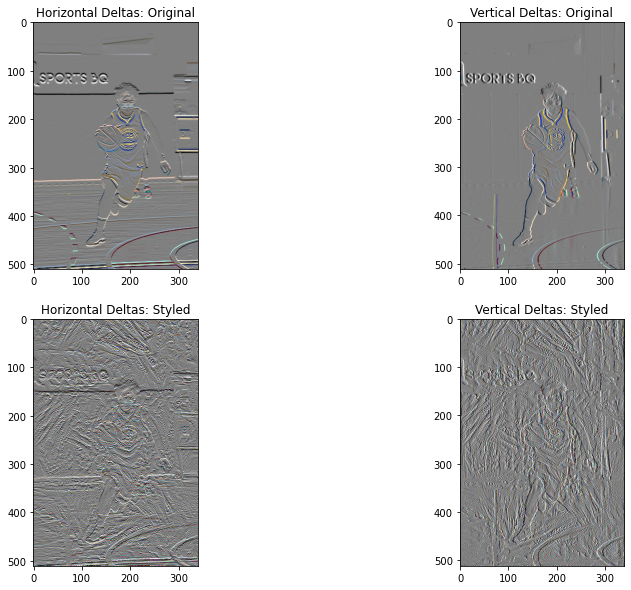

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

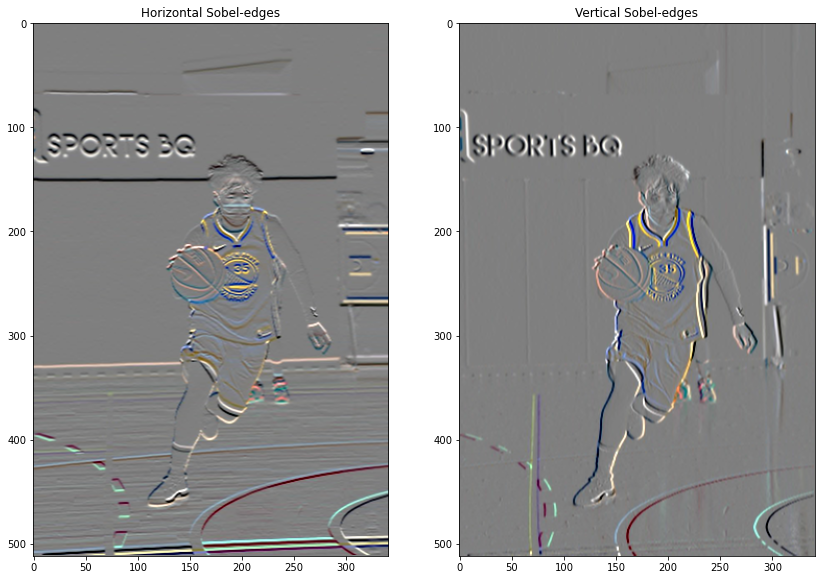

In [28]:
# ex) Sobel edge detector
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [30]:
total_variation_loss(image).numpy()

94054.19

In [31]:
tf.image.total_variation(image).numpy()

array([94054.19], dtype=float32)

# Optimize

In [32]:
total_variation_weight=30

In [33]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [34]:
image = tf.Variable(content_image)

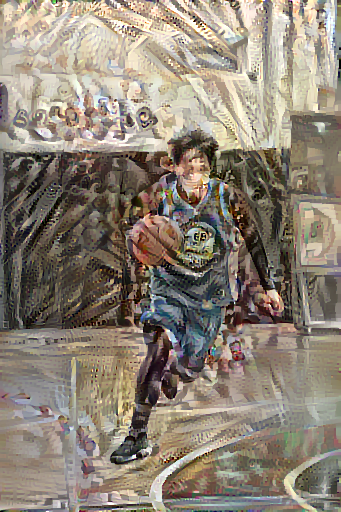

Train Step : 1000
Total Train TIme : 41.5


In [35]:
import time
start = time.time()

epochs = 10
step_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(step_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train Step : {step}")
end = time.time()
print(f"Total Train TIme : {end-start:.1f}")

# Save Result

In [36]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)